# Imports and Gather Images

## Install Addons and import Libraries

In [ ]:
pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install validators

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import numpy as np
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import TensorBoard
import typing
import warnings
from urllib import request
from http import client
import io
import pkg_resources
import validators
import numpy as np
import scipy as sp
import cv2
import PIL
import matplotlib.pyplot as plt
import os
import PIL
import tensorflow as tf
import cv2
from tensorflow.keras.layers import Input , Concatenate , GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from keras.layers import BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Model
from keras.layers import Dense, Dropout, Flatten
import pathlib
import shutil
from tensorflow import keras
from tensorflow.keras import datasets, layers
import math
import zipfile
import glob
import pandas as pd
import tensorflow_addons as tfa

## Import CSV with Labels for Downstream Classification

### Specify File path to CSV in Gdrive

In [ ]:
num_classes = 4
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
mouse_csv_file=pd.read_csv('/content/drive/MyDrive/Cropped_Images_Wound_Stage_Probabilities_Cleaned_No_Ties.csv',index_col='Image')

### Convert CSV To DataFrame Object

In [ ]:
mouse_csv_file[["hemostasis", "inflammatory",'proliferative','maturation']] = mouse_csv_file[["hemostasis", "inflammatory",'proliferative','maturation']].apply(pd.to_numeric)

In [ ]:
cropped_df=pd.DataFrame(mouse_csv_file.idxmax(axis=1),columns=['stage'])

In [ ]:
cropped_df['stage'].replace(["hemostasis", "inflammatory",'proliferative','maturation'],
                        [0, 1,2,3], inplace=True)

In [ ]:
cropped_df

,stage
Image,
Day 8_A8-4-L.png,2
Day 4_A8-3-R.png,1
Day 14_Y8-4-L.png,3
Day 7_Y8-4-L.png,2
Day 2_A8-1-L.png,1
...,...
Day 4_Y8-1-L.png,1
Day 6_Y8-2-L.png,1
Day 5_A8-4-R.png,1


# Create Pairs for Pretext Task

## Train

In [ ]:
#SPLINTELESS DATA
cropped_img_dir="/content/drive/MyDrive/Circle_Cropped_images_Sid/"

In [ ]:
mice_list_types=['_A8-1-','_A8-3-','_A8-4-','_A8-5-','_Y8-1-','_Y8-2-','_Y8-3-','_Y8-4-']

In [ ]:
mice_list_train=['_A8-1-','_A8-3-','_A8-5-','_Y8-1-','_Y8-4-','_Y8-3-']

In [ ]:
def create_pairs_dataset_train():
  days_count = 16
  labels = []
  pairs = []
  
  # Mice pairs generation
  for mice_type in mice_list_train:
    # Iterate forward through the days
    for i in range(days_count-1):
      for j in range(i+1, days_count):
        # Left positive pairs
        left_positive_1 = cropped_img_dir + "Day " + str(i) + mice_type + "L.png"
        left_positive_2 = cropped_img_dir + "Day " + str(j) + mice_type + "L.png"
        # print(left_positive_1 , left_positive_2)
        # Right positive pairs
        right_positive_1 = cropped_img_dir + "Day " + str(i) + mice_type + "R.png"
        right_positive_2 = cropped_img_dir + "Day " + str(j) + mice_type + "R.png"
        # print(right_positive_1 , right_positive_2)
        
        pairs.append((left_positive_1, left_positive_2))
        pairs.append((right_positive_1, right_positive_2))

        labels += [1]
        labels += [1]

    # print()
    # Iterate backward through the days
    for i in reversed(range(days_count)):
      for j in reversed(range(i)):
        # Left negative pairs
        left_negative_1 = cropped_img_dir + "Day " + str(i) + mice_type + "L.png"
        left_negative_2 = cropped_img_dir + "Day " + str(j) + mice_type + "L.png"
        # print("negs are",left_negative_1 , left_negative_2)
        # Right negative pairs
        right_negative_1 = cropped_img_dir + "Day " + str(i) + mice_type + "R.png"
        right_negative_2 = cropped_img_dir + "Day " + str(j) + mice_type + "R.png"
        # print("Neg sare",right_positive_1 , right_positive_2)
        pairs.append((left_negative_1, left_negative_2))
        pairs.append((right_negative_1, right_negative_2))

        labels += [0]
        labels += [0]

  return np.array(pairs), np.array(labels).astype("float32")

In [ ]:
train_pairs, train_labels = create_pairs_dataset_train()

print("Total pairs:", len(train_pairs))
print("Shape of pairs:", train_pairs.shape)
print("Total labels:", len(train_labels))
print("Shape of labels:", train_labels.shape)

Total pairs: 2880
Shape of pairs: (2880, 2)
Total labels: 2880
Shape of labels: (2880,)


In [ ]:
print(train_pairs[18])

['/content/drive/MyDrive/Circle_Cropped_images_Sid/Day 0_A8-1-L.png'
 '/content/drive/MyDrive/Circle_Cropped_images_Sid/Day 10_A8-1-L.png']


In [ ]:
# train_pairs, labels = shuffle(train_pairs, train_labels, random_state=0)

## Test Data and Validation Data

Notice here we specify the wound type to incorporate mices of different age groups 

In [ ]:
mice_list_val=['_A8-4-R','_Y8-2-R']

In [ ]:
def create_pairs_dataset_val():
  
  days_count = 16
  val_pairs=[]
  val_labels=[]

  # Mice pairs generation
  for mice_type in mice_list_val:
    # Iterate forward through the days
    for i in range(days_count-1):
      for j in range(i+1, days_count):
          # Left positive pairs

          right_positive_1 = cropped_img_dir + "Day " + str(i) + mice_type + ".png"
          right_positive_2 = cropped_img_dir + "Day " + str(j) + mice_type + ".png"
          
          val_pairs.append((right_positive_1, right_positive_2))
          val_labels += [1]

    # Iterate backward through the days
    for i in reversed(range(days_count)):
      for j in reversed(range(i)):
        # Left negative pairs
          left_negative_1 = cropped_img_dir + "Day " + str(i) + mice_type + ".png"
          left_negative_2 = cropped_img_dir + "Day " + str(j) + mice_type + ".png"
          
          val_pairs.append((left_negative_1, left_negative_2))
          val_labels += [0]

  return  np.array(val_pairs) , np.array(val_labels).astype("float32")

In [ ]:
val_pairs,val_labels = create_pairs_dataset_val()
print("Total pairs:", len(val_pairs))
print("Shape of pairs:", val_pairs.shape)
print("Total labels:", len(val_labels))
print("Shape of labels:", val_labels.shape)

Total pairs: 480
Shape of pairs: (480, 2)
Total labels: 480
Shape of labels: (480,)


In [ ]:
mice_list_test=['_A8-4-L','_Y8-2-L']

In [ ]:
def create_pairs_dataset_test():
  
  days_count = 16
  test_pairs=[]
  test_labels=[]

  # Mice pairs generation
  for mice_type in mice_list_test:
    # Iterate forward through the days
    for i in range(days_count-1):
      for j in range(i+1, days_count):
          # Left positive pairs

          left_positive_1 = cropped_img_dir + "Day " + str(i) + mice_type + ".png"
          left_positive_2 = cropped_img_dir + "Day " + str(j) + mice_type + ".png"
          
          test_pairs.append((left_positive_1, left_positive_2))
          test_labels += [1]

    # Iterate backward through the days
    for i in reversed(range(days_count)):
      for j in reversed(range(i)):
        # Left negative pairs
          left_negative_1 = cropped_img_dir + "Day " + str(i) + mice_type + ".png"
          left_negative_2 = cropped_img_dir + "Day " + str(j) + mice_type + ".png"
          
          test_pairs.append((left_negative_1, left_negative_2))
          test_labels += [0]

  return  np.array(test_pairs) , np.array(test_labels).astype("float32")

In [ ]:
test_pairs,test_labels = create_pairs_dataset_test()
print()
print("Total pairs:", len(test_pairs))
print("Shape of pairs:", test_pairs.shape)
print("Total labels:", len(test_labels))
print("Shape of labels:", test_labels.shape)


Total pairs: 480
Shape of pairs: (480, 2)
Total labels: 480
Shape of labels: (480,)


## Load Dataset

In [ ]:
#Specify Image size
image_size=224

In [ ]:
#Pil Loader loads images and resizes them to 224 x 224

def pil_loader(path, target_image_shape=(image_size,image_size)):
  # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
  with open(path, 'rb') as f:
    img = PIL.Image.open(f)
    img = np.array(img)
    img = cv2.resize(img, target_image_shape)
    return img

In [ ]:
#Call different test , train , val functions for creating pairs
"""
This funcations returns numpy arrays of left images , right images and labels
"""

def load_dataset_train(n_pairs):
  left_images = []
  right_images = []
  image_labels = []

  for i in range(n_pairs):
    file_l = pathlib.Path(train_pairs[i][0])
    file_r = pathlib.Path(train_pairs[i][1])
    
    if file_l.exists() and file_r.exists():
      left_images += [pil_loader(train_pairs[i][0])]
      right_images += [pil_loader(train_pairs[i][1])]
      image_labels += [train_labels[i]]

  return np.array(left_images), np.array(right_images), np.array(image_labels).astype('float32').reshape((-1,1))


def load_dataset_test(n_pairs):
  left_images = []
  right_images = []
  image_labels = []

  for i in range(n_pairs):
    file_l = pathlib.Path(test_pairs[i][0])
    file_r = pathlib.Path(test_pairs[i][1])
    
    if file_l.exists() and file_r.exists():
      left_images += [pil_loader(test_pairs[i][0])]
      right_images += [pil_loader(test_pairs[i][1])]
      image_labels += [test_labels[i]]

  return np.array(left_images), np.array(right_images), np.array(image_labels).astype('float32').reshape((-1,1))

def load_dataset_val(n_pairs):
  left_images = []
  right_images = []
  image_labels = []

  for i in range(n_pairs):
    file_l = pathlib.Path(val_pairs[i][0])
    file_r = pathlib.Path(val_pairs[i][1])
    
    if file_l.exists() and file_r.exists():
      left_images += [pil_loader(val_pairs[i][0])]
      right_images += [pil_loader(val_pairs[i][1])]
      image_labels += [val_labels[i]]

  return np.array(left_images), np.array(right_images), np.array(image_labels).astype('float32').reshape((-1,1))

In [ ]:
left_train, right_train, labels_train = load_dataset_train(2880)
left_test, right_test, labels_test = load_dataset_test(480)
left_val, right_val, labels_val = load_dataset_val(480)

# Create single Images dataset for downstream classification

In [ ]:
# Old directory contains wound images with splint
# Circle_Cropped_images_Sid contains preprocessed images without splint

directory_train_old = '/content/drive/MyDrive/Wound_images/train/'
directory_test_old = '/content/drive/MyDrive/Wound_images/test/'
directory_val_old = '/content/drive/MyDrive/Wound_images/val/'
directory_new='/content/drive/MyDrive/Circle_Cropped_images_Sid/'

In [ ]:
file_list_test=os.listdir(directory_test_old)
file_list_train=os.listdir(directory_train_old)
file_list_val=os.listdir(directory_val_old)

In [ ]:
def create_train_dataset():
  labels=[]
  dataset=[]
  for file_path in file_list_train:
    dataset.append(directory_new + file_path)
    labels.append(cropped_df.loc[file_path][0])
  return dataset, labels


def create_test_dataset():
  labels=[]
  dataset=[]
  for file_path in file_list_test:
    dataset.append(directory_new + file_path)
    labels.append(cropped_df.loc[file_path][0])

  return dataset, labels

def create_val_dataset():
  labels=[]
  dataset=[]
  for file_path in file_list_val:    
    dataset.append(directory_new + file_path)
    labels.append(cropped_df.loc[file_path][0])

  return dataset, labels

In [ ]:
#These variables hold the image file paths along with the labels from the Labels Dataframe
train_X_dir , train_Y_dir = create_train_dataset()
test_X_dir , test_Y_dir = create_test_dataset()
val_X_dir , val_Y_dir = create_val_dataset()

In [ ]:
print(len(train_X_dir) , len(train_Y_dir))
print(len(val_X_dir) , len(val_Y_dir))
print(len(test_X_dir) , len(test_Y_dir))

191 191
32 32
32 32


In [ ]:
#Pil Loader loads images and resizes them to 224 x 224
def pil_loader_black(path, target_image_shape=(image_size,image_size)):
  # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
  with open(path, 'rb') as f:
    img = PIL.Image.open(f)
    img = np.array(img)
    img = cv2.resize(img, target_image_shape)
    return img

In [ ]:
def load_dataset(pairs,labels):
  images=[]
  image_labels = []

  for i in range(len(pairs)):
    file_dir  = pathlib.Path(pairs[i])
    
    if file_dir.exists():
        images += [pil_loader_black(pairs[i])]      
        image_labels += [labels[i]]
  return images,image_labels

In [ ]:
train_images,train_labels=load_dataset(train_X_dir , train_Y_dir)
test_images,test_labels = load_dataset(test_X_dir , test_Y_dir)
val_images,val_labels = load_dataset(val_X_dir , val_Y_dir)

In [ ]:
print(len(train_images) , len(train_labels))
print(len(val_X_dir) , len(val_Y_dir))
print(len(test_X_dir) , len(test_Y_dir))

191 191
32 32
32 32


/content/drive/MyDrive/Circle_Cropped_images_Sid/Day 0_Y8-3-R.png


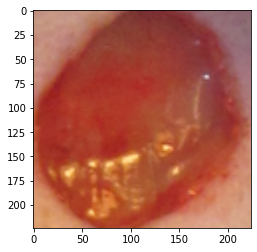

In [ ]:
#Test an image and its directory
print(test_X_dir[2])
plt.imshow(test_images[2])

In [ ]:
#Reshape the images and labels array to Numpy

train_X , train_Y = np.array(train_images),np.array(train_labels).astype('float64').reshape((-1,1))
test_X , test_Y = np.array(test_images),np.array(test_labels).astype('float64').reshape((-1,1))
val_X , val_Y = np.array(val_images),np.array(val_labels).astype('float64').reshape((-1,1))

# Specify parameters for Vision Transformer and Model

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 8
num_epochs = 50
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 4
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier
num_classes = 4

# Define MultiHeadAttention Class and add a DummyLayer which returns weights for Attention maps

## Define Classes

In [ ]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads=4):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        #attention takes three inputs: queries, keys, and  values,
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim)
        self.value_dense = Dense(embed_dim)
        self.combine_heads = Dense(embed_dim)

    def attention(self, query, key, value):
        #use the product between the queries and the keys 
        #to know "how much" each element is the sequence is important with the rest
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        #resulting vector, score is divided by a scaling factor based on the size of the embedding
        #scaling fcator is square root of the embeding dimension
        scaled_score = score / tf.math.sqrt(dim_key)
        #the attention scaled_score is then softmaxed
        weights = tf.nn.softmax(scaled_score, axis=-1)
        #Attention(Q, K, V ) = softmax[(QK)/√dim_key]V
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(
            x, (batch_size, -1, self.num_heads, self.projection_dim)
        )
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
         
        batch_size = tf.shape(inputs)[0]
        #MSA takes the queries, keys, and values  as input from the previous layer 
        #and projects them using the three linear layers.
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )
        #self attention of different heads are concatenated  
        output = self.combine_heads(concat_attention)
        return output , weights                                               

In [ ]:
class DummyLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(DummyLayer, self).__init__()
        # Transfromer block multi-head Self Attention

    def call(self,encoded_patches,weights1):
      return encoded_patches, weights1                                    

## Define Augmentataion Layer and add Positional Embedding , ClassToken and MLP

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.01),
        layers.RandomZoom(
            height_factor=0.1, width_factor=0.1
        ),
        layers.RandomContrast(0.3)
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(left_train)
data_augmentation.layers[0].adapt(right_train)

In [ ]:
class AddPositionEmbsSid(tf.keras.layers.Layer):
    """Adds (optionally learned) positional embeddings to the inputs."""

    def build(self, input_shape):
        assert (
            len(input_shape) == 3
        ), f"Number of dimensions should be 3, got {len(input_shape)}"
        self.pe = tf.Variable(
            name="pos_embedding",
            initial_value=tf.random_normal_initializer(stddev=0.06)(
                shape=(1, input_shape[1], input_shape[2])
            ),
            dtype="float32",
            trainable=True,
        )

    def call(self, inputs):
        return inputs + tf.cast(self.pe, dtype=inputs.dtype)

In [ ]:
# @tf.keras.utils.register_keras_serializable()
class ClassTokenSid(tf.keras.layers.Layer):
    """Append a class token to an input layer."""

    def build(self, input_shape):
        cls_init = tf.zeros_initializer()
        print("Build called")
        self.hidden_size = input_shape[-1]
        self.cls = tf.Variable(
            name="cls",
            initial_value=cls_init(shape=(1, 1, self.hidden_size), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        cls_broadcasted = tf.cast(
            tf.broadcast_to(self.cls, [batch_size, 1, self.hidden_size]),
            dtype=inputs.dtype,
        )
        return tf.concat([cls_broadcasted, inputs], 1)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Create Model Object for ViT Model

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=(image_size, image_size , 3))
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.    
    augmented = tf.keras.layers.Conv2D(
        filters=projection_dim,
        kernel_size=patch_size,
        strides=patch_size,
        padding="valid",
        name="embedding",
    )(inputs)

    #Reshape the augemented images to projection dimension
    y = tf.keras.layers.Reshape((augmented.shape[1] * augmented.shape[2], projection_dim))(augmented)
    #Add the class Token
    y = ClassTokenSid(name="class_token")(y)
    #Append the Positional Embeddings
    encoded_patches = AddPositionEmbsSid(name="Transformer/posembed_input")(y)
    # Create multiple layers of the Transformer block.
    
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output , weights = MultiHeadSelfAttention(
            num_heads=num_heads, embed_dim=projection_dim
        )(x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])
    
        encoded_patches , weight_final = DummyLayer()(encoded_patches,weights)
    
    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    # logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=features)
    
    return model 

In [ ]:
base_densenet_model=create_vit_classifier()


Build called


# Create ViT Encoder Object for Pretext Task

In [ ]:
def create_ViTEncoder(input_shape=(224, 224, 3)):
  # Backbone ViT model
  backbone_model = create_vit_classifier()
  
  input_layer = backbone_model.input
  
  # pooling_layer = tf.keras.layers.AveragePooling2D()(backbone_model.output)
  flatten_layer = tf.keras.layers.Flatten()(backbone_model.output)
  output_layer = tf.keras.layers.Dense(16)(flatten_layer)

  return Model(inputs=input_layer, outputs=output_layer)

def create_ViTHealNet():
  
  ViTEncoder = create_ViTEncoder()

  # ViT model
  left_input = Input(shape=(224,224,3), name="Left input")
  right_input = Input(shape=(224,224,3), name="Right input")

  left_encoder = ViTEncoder(left_input)
  right_encoder = ViTEncoder(right_input)

  merge_layer = Concatenate()([left_encoder, right_encoder])
  output_layer = Dense(1, activation="sigmoid")(merge_layer)

  vithealnet = Model(inputs=[left_input, right_input],
                        outputs=output_layer)
  
  return ViTEncoder, vithealnet

In [ ]:
VIT_encoder, VIT_healnet = create_ViTHealNet()

Build called


#Run Experiments for Prextext Tasks

## Compile and Fit the Model

In [ ]:
VIT_healnet.compile(optimizer=tfa.optimizers.AdamW(learning_rate=learning_rate , weight_decay=weight_decay),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
tf.data.experimental.enable_debug_mode()

VIT_healnet_history = VIT_healnet.fit([left_train, right_train],
                      labels_train,
                      validation_data=([left_val, right_val], labels_val),
                      verbose=1,
                      batch_size=3,
                      epochs=50)

Epoch 1/50
960/960 [==============================] - 49s 31ms/step - loss: 5.4221 - binary_accuracy: 0.6417 - val_loss: 0.5138 - val_binary_accuracy: 0.7333
Epoch 2/50
960/960 [==============================] - 28s 29ms/step - loss: 0.5516 - binary_accuracy: 0.7573 - val_loss: 0.4311 - val_binary_accuracy: 0.8156
Epoch 3/50
960/960 [==============================] - 29s 30ms/step - loss: 0.4947 - binary_accuracy: 0.7903 - val_loss: 0.3866 - val_binary_accuracy: 0.8244
Epoch 4/50
960/960 [==============================] - 29s 30ms/step - loss: 0.4486 - binary_accuracy: 0.8059 - val_loss: 0.3825 - val_binary_accuracy: 0.8444
Epoch 5/50
960/960 [==============================] - 28s 29ms/step - loss: 0.4188 - binary_accuracy: 0.8285 - val_loss: 0.3396 - val_binary_accuracy: 0.8400
Epoch 6/50
960/960 [==============================] - 28s 29ms/step - loss: 0.3821 - binary_accuracy: 0.8413 - val_loss: 0.3257 - val_binary_accuracy: 0.8578
Epoch 7/50
960/960 [==============================] 

## Graphs and Test Accuracy on Pretext Task

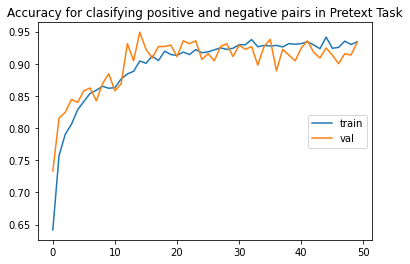

In [ ]:
# summarize history for accuracy
plt.plot(VIT_healnet_history.history['binary_accuracy'])
plt.plot(VIT_healnet_history.history['val_binary_accuracy'])
plt.title('Accuracy for clasifying positive and negative pairs in Pretext Task')
plt.legend(['train', 'val'], loc='right')
plt.show()

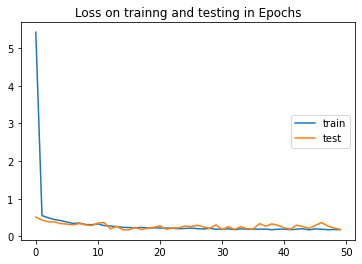

In [ ]:
# summarize history for loss
plt.plot(VIT_healnet_history.history['loss'])
plt.plot(VIT_healnet_history.history['val_loss'])
plt.title('Loss on trainng and testing in Epochs')
plt.legend(['train', 'test'], loc='right')
plt.show()

In [ ]:
loss, acc = VIT_healnet.evaluate([left_test, right_test], labels_test, verbose=1)
print("Accuracy: {:5.2f}%".format(100 * acc))

15/15 [==============================] - 2s 28ms/step - loss: 0.4952 - binary_accuracy: 0.8354
Accuracy: 83.54%


# Display patches

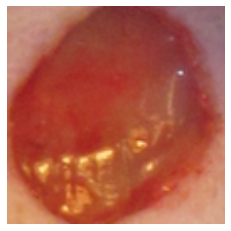

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = right_train[58]
plt.imshow(image.astype("uint8"))
plt.axis("off")
plt.savefig('original_image_1.png' , bbox_inches='tight',pad_inches = 0)
# resized_image = tf.image.resize(
#     tf.convert_to_tensor([image]), size=(image_size, image_size)
# )
# patches = Patches(patch_size)(resized_image)
# print(f"Image size: {image_size} X {image_size}")
# print(f"Patch size: {patch_size} X {patch_size}")
# print(f"Patches per image: {patches.shape[1]}")
# print(f"Elements per patch: {patches.shape[-1]}")

# n = int(np.sqrt(patches.shape[1]))
# plt.figure(figsize=(4, 4))
# for i, patch in enumerate(patches[0]):
#     ax = plt.subplot(n, n, i + 1)
#     patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
#     plt.imshow(patch_img.numpy().astype("uint8"))
#     plt.axis("off")

# plt.savefig('patched_image_1.png' , bbox_inches='tight',pad_inches = 0)

# Clustering Process from ViT Encoder

## Create function to get predictions on test,val,train set based on embedding

In [ ]:
def create_features_common(i:str):
  all_preds = []
  
  dir='/content/drive/MyDrive/Wound_images/'+ i +'/'
  dir_new ='/content/drive/MyDrive/Circle_Cropped_images_Sid/'

  file_list=os.listdir(dir)
  
  for file in file_list:

    path=dir_new+file

    img = pil_loader(path)

    img=tf.expand_dims(img, axis=0)

    pred=VIT_encoder.predict(img)
    
    all_preds.append(pred[0])

  return np.array(all_preds)

## Get all predictions from ViT Encoder

In [ ]:
train_embeddings=create_features_common('train')
test_embeddings=create_features_common('test')
val_embeddings=create_features_common('val')

In [ ]:
print("Train Embedding are ",train_embeddings.shape)
print("Test Embedding are " ,test_embeddings.shape)
print("Val Embedding are " ,val_embeddings.shape)

Train Embedding are  (191, 16)
Test Embedding are  (32, 16)
Val Embedding are  (32, 16)


## Perform Kmeans Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn import datasets
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Fit K-means Clusters on train embeddings
kmeans = KMeans(n_clusters=4, random_state=0).fit(train_embeddings)
print("Predicted train labels:", kmeans.labels_)
# Cluster test embeddings
print("Predicted test labels:", kmeans.predict(test_embeddings))

Predicted train labels: [0 3 3 3 3 0 0 2 2 3 3 2 0 2 3 2 3 1 2 1 2 2 2 1 1 1 2 2 2 2 1 1 2 1 1 1 1
 2 2 1 2 2 2 1 1 1 2 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 2 2 1 1 2 1 1 1 2 1 1 1
 1 1 1 3 3 0 3 0 1 0 1 0 1 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0
 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 2 0 0 2 0 2 2 2 2 2 0 0 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 1 2 2 1 1]
Predicted test labels: [3 2 3 1 1 1 2 1 1 1 1 1 1 0 1 3 3 0 0 2 0 0 0 2 0 2 2 2 2 2 2 1]


In [ ]:
cluster_group_train=kmeans.labels_
cluster_group_test=kmeans.predict(test_embeddings)
cluster_group_val=kmeans.predict(val_embeddings)

## View Clusters

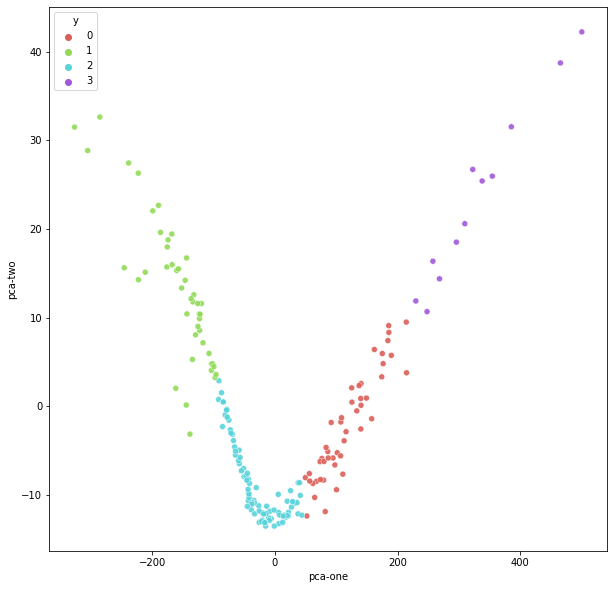

In [ ]:
# Fit PCA on Test embeddings
pca = decomposition.PCA(n_components=2)
pca.fit(train_embeddings)

# Plot Train Data PCA
X = pca.transform(train_embeddings)
df = pd.DataFrame(X,columns=['pca-one', 'pca-two'])
df['y'] = kmeans.labels_
plt.figure(figsize=(10,10));
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 4),
    data=df,
    legend="full",
    alpha=0.9
)


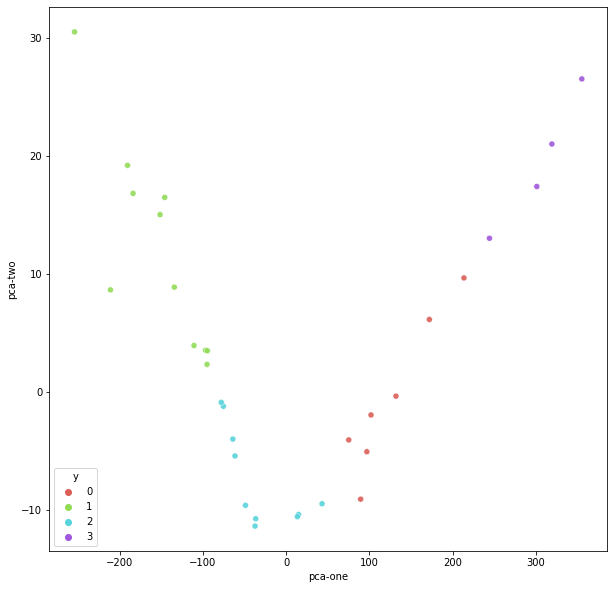

In [ ]:
# Plot test Data PCA
X = pca.transform(test_embeddings)
df = pd.DataFrame(X,columns=['pca-one', 'pca-two'])
df['y'] = kmeans.predict(test_embeddings)
plt.figure(figsize=(10,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 4),
    data=df,
    legend="full",
    alpha=0.9
)

In [ ]:
train_labels = kmeans.predict(train_embeddings)
test_labels = kmeans.predict(test_embeddings)
val_labels = kmeans.predict(val_embeddings)

In [ ]:
print(train_labels.shape)

(191,)


#Create Image - Label Pair with Clusters Created for Test , Val , Train set


In [ ]:
def clustered_label_pair(i:str):
  image_labels = []
  
  image_list=[]
  
  dir='/content/drive/MyDrive/Wound_images/'+ i +'/'
  dir_new ='/content/drive/MyDrive/Circle_Cropped_images_Sid/'
  
  file_list=os.listdir(dir)
  
  count=0
  
  for file in file_list: 
    if i=="train":
      image=pil_loader(dir_new+file)
      label=train_labels[count]

      image_list.append(image)
      image_labels.append(label)
    
    elif i=="val":
      # print("inside val")
      image=pil_loader(dir_new+file)
      label=val_labels[count]

      image_list.append(image)
      image_labels.append(label)

    elif i=="test":
      # print("inside test")
      image=pil_loader(dir_new+file)
      label=test_labels[count]

      image_list.append(image)
      image_labels.append(label)

    count+=1

  return np.array(image_list) , np.array(image_labels).astype('float32').reshape((-1,1))

In [ ]:
train_clustered_images , train_clustered_labels = clustered_label_pair('train')
test_clustered_images , test_clustered_labels = clustered_label_pair('test')
val_clustered_images , val_clustered_labels = clustered_label_pair('val')

# Create Classifier and Compile and Run it

## Create Downstream Classifier Using the Clustering Labels

In [ ]:
num_classes=4

def downstream_classifier():
  pretext_trained_ViT= VIT_encoder
  
  output_layer = tf.keras.layers.Dense(4)(pretext_trained_ViT.output)
  return Model(inputs=pretext_trained_ViT.input , outputs=output_layer)

In [ ]:
downstream_model_clustered=downstream_classifier()

## Compile and Run Downstream Using CLustering Labels

In [ ]:
downstream_model_clustered.compile(optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=weight_decay),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")])

In [ ]:
tf.data.experimental.enable_debug_mode()

downstream_model_clustered_history = downstream_model_clustered.fit(train_clustered_images,
                      train_clustered_labels,
                      validation_data=(val_clustered_images, val_clustered_labels),
                      verbose=1,
                      batch_size=8,
                      epochs=50)

Epoch 1/50
24/24 [==============================] - 7s 63ms/step - loss: 7.9456 - accuracy: 0.5654 - val_loss: 0.8268 - val_accuracy: 0.7812
Epoch 2/50
24/24 [==============================] - 1s 30ms/step - loss: 1.2263 - accuracy: 0.6597 - val_loss: 0.5467 - val_accuracy: 0.6875
Epoch 3/50
24/24 [==============================] - 1s 31ms/step - loss: 0.6734 - accuracy: 0.7644 - val_loss: 0.2258 - val_accuracy: 0.9375
Epoch 4/50
24/24 [==============================] - 1s 32ms/step - loss: 0.6595 - accuracy: 0.7592 - val_loss: 0.7326 - val_accuracy: 0.8125
Epoch 5/50
24/24 [==============================] - 1s 31ms/step - loss: 0.5644 - accuracy: 0.8168 - val_loss: 0.3426 - val_accuracy: 0.8750
Epoch 6/50
24/24 [==============================] - 1s 31ms/step - loss: 0.4960 - accuracy: 0.8325 - val_loss: 0.2515 - val_accuracy: 0.8750
Epoch 7/50
24/24 [==============================] - 1s 31ms/step - loss: 0.5378 - accuracy: 0.8325 - val_loss: 0.7501 - val_accuracy: 0.8125
Epoch 8/50
24

In [ ]:
_, accuracy = downstream_model_clustered.evaluate(test_clustered_images, test_clustered_labels)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

1/1 [==============================] - 1s 641ms/step - loss: 0.5594 - accuracy: 0.8750
Test accuracy: 87.5%


# View Maps for Clustered Images

## View Maps

/content/drive/MyDrive/Circle_Cropped_images_Sid/Day 4_A8-4-R.png


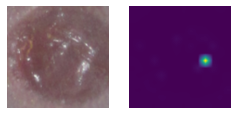

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
# from . import layers, vit


def attention_map(model, image):
    """Get an attention map for an image and model using the technique
    described in Appendix D.7 in the paper (unofficial).
    Args:
        model: A ViT model
        image: An image for which we will compute the attention map.
    """
    
    
    size = model.input_shape[1]
    
    grid_size = int(np.sqrt(model.layers[14].output_shape[0][-2] - 1))
    
    img1=cv2.resize(image, (size, size))
    X= img1[np.newaxis, :]
    # Get the attention weights from each transformer.
    outputs = [
        l.output[1] for l in model.layers if isinstance(l, DummyLayer)
    ]

    weights = np.array(
        tf.keras.models.Model(inputs=model.inputs, outputs=outputs).predict(X)
    )
    
    
    num_layers = weights.shape[0]
    num_heads = weights.shape[2]
    
    reshaped = weights.reshape(
        (num_layers, num_heads, grid_size ** 2 + 1, grid_size ** 2 + 1 )
    )
    
    # From Appendix D.6 in the paper ...
    # Average the attention weights across all heads.
    reshaped = reshaped.mean(axis=1)

    # From Section 3 in https://arxiv.org/pdf/2005.00928.pdf ...
    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    reshaped = reshaped + np.eye(reshaped.shape[2])
    reshaped = reshaped / reshaped.sum(axis=(1, 2))[:, np.newaxis, np.newaxis]
    
    v = reshaped[-1]
    for n in range(1, len(reshaped)):
        v = np.matmul(v, reshaped[-1 - n])


    get_mask=True
    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size)

    if get_mask:
      result = cv2.resize(mask / mask.max(), (image_size,image_size))
    else:
      mask = cv2.resize(mask / mask.max(), (image.shape[1], image.shape[0]))[
          ..., np.newaxis
          ]
      result= (mask * image).astype("uint8")

    return result

dir_new ='/content/drive/MyDrive/Circle_Cropped_images_Sid/'
#Change at line 70 for testing files in training ,validation and test set
test_file_list= os.listdir('/content/drive/MyDrive/Wound_images/test/')
#Change at line 71 for checking with different wound images , like 19,20,21,22.......
new_file=dir_new+test_file_list[19]

#Prints the file which we are seeing
print(new_file)
img = PIL.Image.open(new_file)
image = np.array(img)
image = cv2.resize(image, (image_size,image_size))

attention_map = attention_map(model=downstream_model_clustered, image=image)
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(4,4))


ax1.axis('off')
ax2.axis('off')

_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)


## View and Save only original Image

/content/drive/MyDrive/Circle_Cropped_images_Sid/Day 4_A8-4-R.png


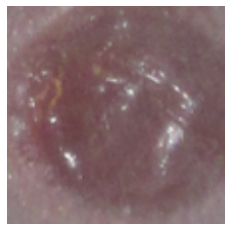

In [ ]:
import cv2
import numpy as np
import tensorflow as tf


def attention_map(model, image):
    """Get an attention map for an image and model using the technique
    described in Appendix D.7 in the paper (unofficial).
    Args:
        model: A ViT model
        image: An image for which we will compute the attention map.
    """
    size = model.input_shape[1]
    grid_size = int(np.sqrt(model.layers[14].output_shape[0][-2] - 1))
    img1=cv2.resize(image, (size, size))
    
    X= img1[np.newaxis, :]
    # Get the attention weights from each transformer.
    outputs = [
        l.output[1] for l in model.layers if isinstance(l, DummyLayer)
    ]

    
    weights = np.array(
        tf.keras.models.Model(inputs=model.inputs, outputs=outputs).predict(X)
    )
    
    
    num_layers = weights.shape[0]
    num_heads = weights.shape[2]
    
    reshaped = weights.reshape(
        (num_layers, num_heads, grid_size ** 2 + 1, grid_size ** 2 + 1 )
    )
    
    # From Appendix D.6 in the paper ...
    # Average the attention weights across all heads.
    reshaped = reshaped.mean(axis=1)

    # From Section 3 in https://arxiv.org/pdf/2005.00928.pdf ...
    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    reshaped = reshaped + np.eye(reshaped.shape[2])
    reshaped = reshaped / reshaped.sum(axis=(1, 2))[:, np.newaxis, np.newaxis]
    
    v = reshaped[-1]
    for n in range(1, len(reshaped)):
        v = np.matmul(v, reshaped[-1 - n])


    get_mask=True
    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size)

    if get_mask:
      result = cv2.resize(mask / mask.max(), (image_size,image_size))
    else:
      mask = cv2.resize(mask / mask.max(), (image.shape[1], image.shape[0]))[
          ..., np.newaxis
          ]
      result= (mask * image).astype("uint8")

    return result

dir_new ='/content/drive/MyDrive/Circle_Cropped_images_Sid/'
#Change at line 70 for testing files in training ,validation and test set
test_file_list= os.listdir('/content/drive/MyDrive/Wound_images/test/')
#Change at line 71 for checking with different wound images , like 19,20,21,22.......
new_file=dir_new+test_file_list[19]

#Prints the file which we are seeing
print(new_file)
img = PIL.Image.open(new_file)
image = np.array(img)
image = cv2.resize(image, (image_size,image_size))


attention_map = attention_map(model=downstream_model_clustered, image=image)

fig,ax1 = plt.subplots(ncols=1,figsize=(4,4))

ax1.axis('off')

_ = ax1.imshow(image)

plt.savefig("Original file for "+new_file[49:63] +".png", bbox_inches='tight',pad_inches = 0)

## View and Save only Aggregate Layer

/content/drive/MyDrive/Circle_Cropped_images_Sid/Day 4_A8-4-R.png


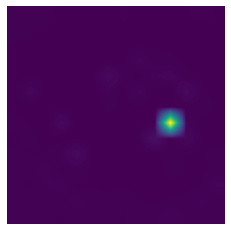

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
# from . import layers, vit


def attention_map(model, image):
    """Get an attention map for an image and model using the technique
    described in Appendix D.7 in the paper (unofficial).
    Args:
        model: A ViT model
        image: An image for which we will compute the attention map.
    """
    
    size = model.input_shape[1]
    grid_size = int(np.sqrt(model.layers[14].output_shape[0][-2] - 1))
    img1=cv2.resize(image, (size, size))
    X= img1[np.newaxis, :]
    # Get the attention weights from each transformer.
    outputs = [
        l.output[1] for l in model.layers if isinstance(l, DummyLayer)
    ]

    weights = np.array(
        tf.keras.models.Model(inputs=model.inputs, outputs=outputs).predict(X)
    )
    
    num_layers = weights.shape[0]
    num_heads = weights.shape[2]
    
    reshaped = weights.reshape(
        (num_layers, num_heads, grid_size ** 2 + 1, grid_size ** 2 + 1 )
    )
    
    # From Appendix D.6 in the paper ...
    # Average the attention weights across all heads.
    reshaped = reshaped.mean(axis=1)

    # From Section 3 in https://arxiv.org/pdf/2005.00928.pdf ...
    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    reshaped = reshaped + np.eye(reshaped.shape[2])
    reshaped = reshaped / reshaped.sum(axis=(1, 2))[:, np.newaxis, np.newaxis]
    
    v = reshaped[-1]
    for n in range(1, len(reshaped)):
        v = np.matmul(v, reshaped[-1 - n])


    get_mask=True
    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size)

    if get_mask:
      result = cv2.resize(mask / mask.max(), (image_size,image_size))
    else:
      mask = cv2.resize(mask / mask.max(), (image.shape[1], image.shape[0]))[
          ..., np.newaxis
          ]
      result= (mask * image).astype("uint8")

    return result


dir_new ='/content/drive/MyDrive/Circle_Cropped_images_Sid/'
#Change at line 70 for testing files in training ,validation and test set
test_file_list= os.listdir('/content/drive/MyDrive/Wound_images/test/')
#Change at line 71 for checking with different wound images , like 19,20,21,22.......
new_file=dir_new+test_file_list[19]

#Prints the file which we are seeing
print(new_file)
img = PIL.Image.open(new_file)
image = np.array(img)
image = cv2.resize(image, (image_size,image_size))


attention_map = attention_map(model=downstream_model_clustered, image=image)

fig,ax2 = plt.subplots(ncols=1,figsize=(4,4))
ax2.axis('off')

_ = ax2.imshow(attention_map)

plt.savefig(new_file[49:63]+" Aggregate "+".png" , bbox_inches='tight',pad_inches = 0)

## View and Save only Layer1 attention

/content/drive/MyDrive/Circle_Cropped_images_Sid/Day 4_A8-4-R.png


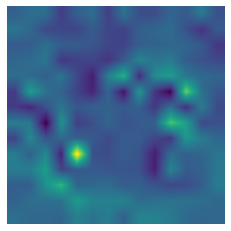

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
# from . import layers, vit


def attention_map(model, image):
    """Get an attention map for an image and model using the technique
    described in Appendix D.7 in the paper (unofficial).
    Args:
        model: A ViT model
        image: An image for which we will compute the attention map.
    """
    size = model.input_shape[1]
    grid_size = int(np.sqrt(model.layers[14].output_shape[0][-2] - 1))
    img1=cv2.resize(image, (size, size))
    
    X= img1[np.newaxis, :]
    # Get the attention weights from each transformer.
    outputs = [
        l.output[1] for l in model.layers if isinstance(l, DummyLayer)
    ]
    weights = np.array(
        tf.keras.models.Model(inputs=model.inputs, outputs=outputs[0]).predict(X)
    )
    
    num_layers = weights.shape[0]
    num_heads = weights.shape[1]
    
    reshaped = weights.reshape(
        (num_layers, num_heads, grid_size ** 2 + 1, grid_size ** 2 + 1 )
    )
    
    # From Appendix D.6 in the paper ...
    # Average the attention weights across all heads.
    reshaped = reshaped.mean(axis=1)

    # From Section 3 in https://arxiv.org/pdf/2005.00928.pdf ...
    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    reshaped = reshaped + np.eye(reshaped.shape[2])
    reshaped = reshaped / reshaped.sum(axis=(1, 2))[:, np.newaxis, np.newaxis]
    
    v = reshaped[-1]
    for n in range(1, len(reshaped)):
        v = np.matmul(v, reshaped[-1 - n])


    get_mask=True
    
    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size)

    if get_mask:
      result = cv2.resize(mask / mask.max(), (image_size,image_size))
    else:
      mask = cv2.resize(mask / mask.max(), (image.shape[1], image.shape[0]))[
          ..., np.newaxis
          ]
      result= (mask * image).astype("uint8")

    return result


dir_new ='/content/drive/MyDrive/Circle_Cropped_images_Sid/'
#Change at line 70 for testing files in training ,validation and test set
test_file_list= os.listdir('/content/drive/MyDrive/Wound_images/test/')
#Change at line 71 for checking with different wound images , like 19,20,21,22.......
new_file=dir_new+test_file_list[19]

#Prints the file which we are seeing
print(new_file)

img = PIL.Image.open(new_file)
image = np.array(img)
image = cv2.resize(image, (image_size,image_size))


attention_map = attention_map(model=downstream_model_clustered, image=image)

fig,ax2 = plt.subplots(ncols=1,figsize=(4,4))
ax2.axis('off')
_ = ax2.imshow(attention_map)

plt.savefig(new_file[49:63]+"Layer 1"+".png" , bbox_inches='tight',pad_inches = 0)


## View and Save only Layer 2 attention

/content/drive/MyDrive/Circle_Cropped_images_Sid/Day 4_A8-4-R.png
Img 1 shape is  (224, 224, 3)


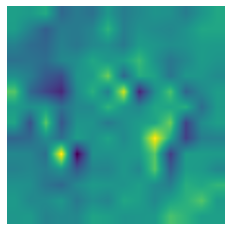

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
# from . import layers, vit


def attention_map(model, image):
    """Get an attention map for an image and model using the technique
    described in Appendix D.7 in the paper (unofficial).
    Args:
        model: A ViT model
        image: An image for which we will compute the attention map.
    """
    
    size = model.input_shape[1]
    grid_size = int(np.sqrt(model.layers[14].output_shape[0][-2] - 1))
    img1=cv2.resize(image, (size, size))
    print("Img 1 shape is ",img1.shape)
    X= img1[np.newaxis, :]
    # Get the attention weights from each transformer.
    outputs = [
        l.output[1] for l in model.layers if isinstance(l, DummyLayer)
    ]

    weights = np.array(
        tf.keras.models.Model(inputs=model.inputs, outputs=outputs[1]).predict(X)
    )
    
    num_layers = weights.shape[0]
    num_heads = weights.shape[1]
    
    reshaped = weights.reshape(
        (num_layers, num_heads, grid_size ** 2 + 1, grid_size ** 2 + 1 )
    )
    # From Appendix D.6 in the paper ...
    # Average the attention weights across all heads.
    reshaped = reshaped.mean(axis=1)

    # From Section 3 in https://arxiv.org/pdf/2005.00928.pdf ...
    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    reshaped = reshaped + np.eye(reshaped.shape[2])
    reshaped = reshaped / reshaped.sum(axis=(1, 2))[:, np.newaxis, np.newaxis]
    
    v = reshaped[-1]
    for n in range(1, len(reshaped)):
        v = np.matmul(v, reshaped[-1 - n])


    get_mask=True
    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size)

    if get_mask:
      result = cv2.resize(mask / mask.max(), (image_size,image_size))
    else:
      mask = cv2.resize(mask / mask.max(), (image.shape[1], image.shape[0]))[
          ..., np.newaxis
          ]
      result= (mask * image).astype("uint8")

    return result



dir_new ='/content/drive/MyDrive/Circle_Cropped_images_Sid/'
#Change at line 70 for testing files in training ,validation and test set
test_file_list= os.listdir('/content/drive/MyDrive/Wound_images/test/')
#Change at line 71 for checking with different wound images , like 19,20,21,22.......
new_file=dir_new+test_file_list[19]

#Prints the file which we are seeing
print(new_file)
img = PIL.Image.open(new_file)
image = np.array(img)
image = cv2.resize(image, (image_size,image_size))


attention_map = attention_map(model=downstream_model_clustered, image=image)

fig,ax2 = plt.subplots(ncols=1,figsize=(4,4))
ax2.axis('off')

_ = ax2.imshow(attention_map)

plt.savefig(new_file[49:63]+"Layer 2" +".png", bbox_inches='tight',pad_inches = 0)

## View and Save only Layer 3 attention

/content/drive/MyDrive/Circle_Cropped_images_Sid/Day 4_A8-4-R.png
Img 1 shape is  (224, 224, 3)


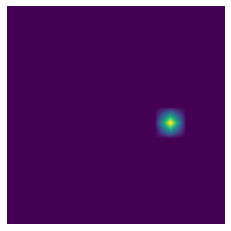

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
# from . import layers, vit


def attention_map(model, image):
    """Get an attention map for an image and model using the technique
    described in Appendix D.7 in the paper (unofficial).
    Args:
        model: A ViT model
        image: An image for which we will compute the attention map.
    """
    
    size = model.input_shape[1]
    grid_size = int(np.sqrt(model.layers[14].output_shape[0][-2] - 1))
    img1=cv2.resize(image, (size, size))
    print("Img 1 shape is ",img1.shape)
    X= img1[np.newaxis, :]
    # Get the attention weights from each transformer.
    outputs = [
        l.output[1] for l in model.layers if isinstance(l, DummyLayer)
    ]

    weights = np.array(
        tf.keras.models.Model(inputs=model.inputs, outputs=outputs[2]).predict(X)
    )
    
    num_layers = weights.shape[0]
    num_heads = weights.shape[1]
    
    reshaped = weights.reshape(
        (num_layers, num_heads, grid_size ** 2 + 1, grid_size ** 2 + 1 )
    )
    
    # From Appendix D.6 in the paper ...
    # Average the attention weights across all heads.
    reshaped = reshaped.mean(axis=1)

    # From Section 3 in https://arxiv.org/pdf/2005.00928.pdf ...
    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    reshaped = reshaped + np.eye(reshaped.shape[2])
    reshaped = reshaped / reshaped.sum(axis=(1, 2))[:, np.newaxis, np.newaxis]
    
    v = reshaped[-1]
    for n in range(1, len(reshaped)):
        v = np.matmul(v, reshaped[-1 - n])


    get_mask=True
    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size)

    if get_mask:
      result = cv2.resize(mask / mask.max(), (image_size,image_size))
    else:
      mask = cv2.resize(mask / mask.max(), (image.shape[1], image.shape[0]))[
          ..., np.newaxis
          ]
      result= (mask * image).astype("uint8")

    return result

dir_new ='/content/drive/MyDrive/Circle_Cropped_images_Sid/'
#Change at line 70 for testing files in training ,validation and test set
test_file_list= os.listdir('/content/drive/MyDrive/Wound_images/test/')
#Change at line 71 for checking with different wound images , like 19,20,21,22.......
new_file=dir_new+test_file_list[19]

#Prints the file which we are seeing
print(new_file)
img = PIL.Image.open(new_file)
image = np.array(img)
image = cv2.resize(image, (image_size,image_size))


attention_map = attention_map(model=downstream_model_clustered, image=image)

fig,ax2 = plt.subplots(ncols=1,figsize=(4,4))
ax2.axis('off')

_ = ax2.imshow(attention_map)

plt.savefig(new_file[49:63]+"Layer 3" +".png", bbox_inches='tight',pad_inches = 0)


## View and Save only Layer 4 attention

/content/drive/MyDrive/Circle_Cropped_images_Sid/Day 4_A8-4-R.png
Img 1 shape is  (224, 224, 3)


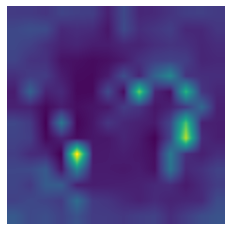

In [ ]:
import cv2
import numpy as np
import tensorflow as tf



def attention_map(model, image):
    """Get an attention map for an image and model using the technique
    described in Appendix D.7 in the paper (unofficial).
    Args:
        model: A ViT model
        image: An image for which we will compute the attention map.
    """
    
    size = model.input_shape[1]
    grid_size = int(np.sqrt(model.layers[14].output_shape[0][-2] - 1))
    img1=cv2.resize(image, (size, size))
    print("Img 1 shape is ",img1.shape)
    X= img1[np.newaxis, :]
    # Get the attention weights from each transformer.
    outputs = [
        l.output[1] for l in model.layers if isinstance(l, DummyLayer)
    ]

    weights = np.array(
        tf.keras.models.Model(inputs=model.inputs, outputs=outputs[3]).predict(X)
    )
    
    num_layers = weights.shape[0]
    num_heads = weights.shape[1]
    
    reshaped = weights.reshape(
        (num_layers, num_heads, grid_size ** 2 + 1, grid_size ** 2 + 1 )
    )
    
    # From Appendix D.6 in the paper ...
    # Average the attention weights across all heads.
    reshaped = reshaped.mean(axis=1)

    # From Section 3 in https://arxiv.org/pdf/2005.00928.pdf ...
    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    reshaped = reshaped + np.eye(reshaped.shape[2])
    reshaped = reshaped / reshaped.sum(axis=(1, 2))[:, np.newaxis, np.newaxis]
    
    v = reshaped[-1]
    for n in range(1, len(reshaped)):
        v = np.matmul(v, reshaped[-1 - n])


    get_mask=True
    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size)

    if get_mask:
      result = cv2.resize(mask / mask.max(), (image_size,image_size))
    else:
      mask = cv2.resize(mask / mask.max(), (image.shape[1], image.shape[0]))[
          ..., np.newaxis
          ]
      result= (mask * image).astype("uint8")

    return result

dir_new ='/content/drive/MyDrive/Circle_Cropped_images_Sid/'
#Change at line 70 for testing files in training ,validation and test set
test_file_list= os.listdir('/content/drive/MyDrive/Wound_images/test/')
#Change at line 71 for checking with different wound images , like 19,20,21,22.......
new_file=dir_new+test_file_list[19]

#Prints the file which we are seeing
print(new_file)

img = PIL.Image.open(new_file)
image = np.array(img)
image = cv2.resize(image, (image_size,image_size))


attention_map = attention_map(model=downstream_model_clustered, image=image)

fig,ax2 = plt.subplots(ncols=1,figsize=(4,4))
ax2.axis('off')

_ = ax2.imshow(attention_map)

plt.savefig(new_file[49:63]+"Layer 4" +".png", bbox_inches='tight',pad_inches = 0)

## Accuracy

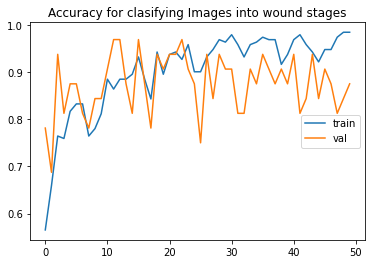

In [ ]:
plt.plot(downstream_model_clustered_history.history['accuracy'])
plt.plot(downstream_model_clustered_history.history['val_accuracy'])
plt.title('Accuracy for clasifying Images into wound stages')
plt.legend(['train', 'val'], loc='right')
plt.show()

## Losses

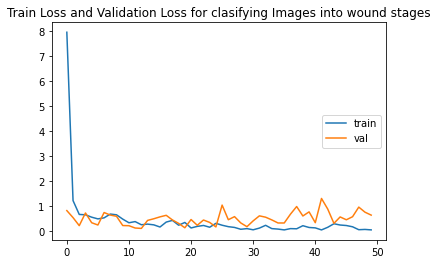

In [ ]:
# summarize history for loss
plt.plot(downstream_model_clustered_history.history['loss'])
plt.plot(downstream_model_clustered_history.history['val_loss'])
plt.title('Train Loss and Validation Loss for clasifying Images into wound stages')
plt.legend(['train', 'val'], loc='right')
plt.show()